# Custom indicator example

In [11]:
import logging
import yfinance as yf

from mplchart.chart import Chart

from mplchart.library import get_series, calc_ema
from mplchart.primitives import Candlesticks, OHLC, Volume

from dataclasses import dataclass

logging.basicConfig(level=logging.INFO)

In [12]:
ticker = "AAPL"
prices = yf.Ticker(ticker).history(period="5y")
prices

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-15 00:00:00-04:00,44.488715,45.085587,44.221566,44.794369,156171600,0.0,0.0
2019-03-18 00:00:00-04:00,44.717357,45.340704,44.714948,45.251656,104879200,0.0,0.0
2019-03-19 00:00:00-04:00,45.331077,45.485109,44.746236,44.893047,126585600,0.0,0.0
2019-03-20 00:00:00-04:00,44.820851,45.605452,44.459838,45.285355,124140800,0.0,0.0
2019-03-21 00:00:00-04:00,45.733009,47.251666,45.682466,46.953228,204136800,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-08 00:00:00-05:00,169.000000,173.699997,168.940002,170.729996,76114600,0.0,0.0
2024-03-11 00:00:00-04:00,172.940002,174.380005,172.050003,172.750000,60139500,0.0,0.0
2024-03-12 00:00:00-04:00,173.149994,174.029999,171.009995,173.229996,59825400,0.0,0.0


In [16]:
from mplchart.utils import series_xy


class LoggedAccess:
    def __set_name__(self, owner, name):
        self.name = name

    def __get__(self, obj, objtype=None):
        value = getattr(obj, self.private_name)
        logging.info('Accessing %r giving %r', self.public_name, value)
        return value

    def __set__(self, obj, value):
        logging.info('Updating %r to %r', self.public_name, value)
        setattr(obj, self.private_name, value)

@dataclass
class DEMA:
    """Double Exponential Moving Average"""

    period: int = 20

    same_scale = True
    # same_scale is an optional class attribute
    # to specify that the indicator can be drawn
    # on the same axes as the previous indicator

    def __call__(self, prices):
        series = get_series(prices)
        ema1 = calc_ema(series, self.period)
        ema2 = calc_ema(ema1, self.period)
        return 2 * ema1 - ema2
    
    def plot_result(self, data, chart, ax=None):
        logging.info("plot_result")
        
        if ax is None:
            ax = chart.get_axes("samex")

        label = repr(self)
        xv, yv = series_xy(data)

        ax.plot(xv, yv, label=label)


            

In [17]:
res = DEMA(20)(prices)
res.tail()

Date
2024-03-08 00:00:00-05:00    173.156326
2024-03-11 00:00:00-04:00    172.613383
2024-03-12 00:00:00-04:00    172.257246
2024-03-13 00:00:00-04:00    171.593588
2024-03-14 00:00:00-04:00    171.385344
Name: close, dtype: float64

INFO:root:plot_result


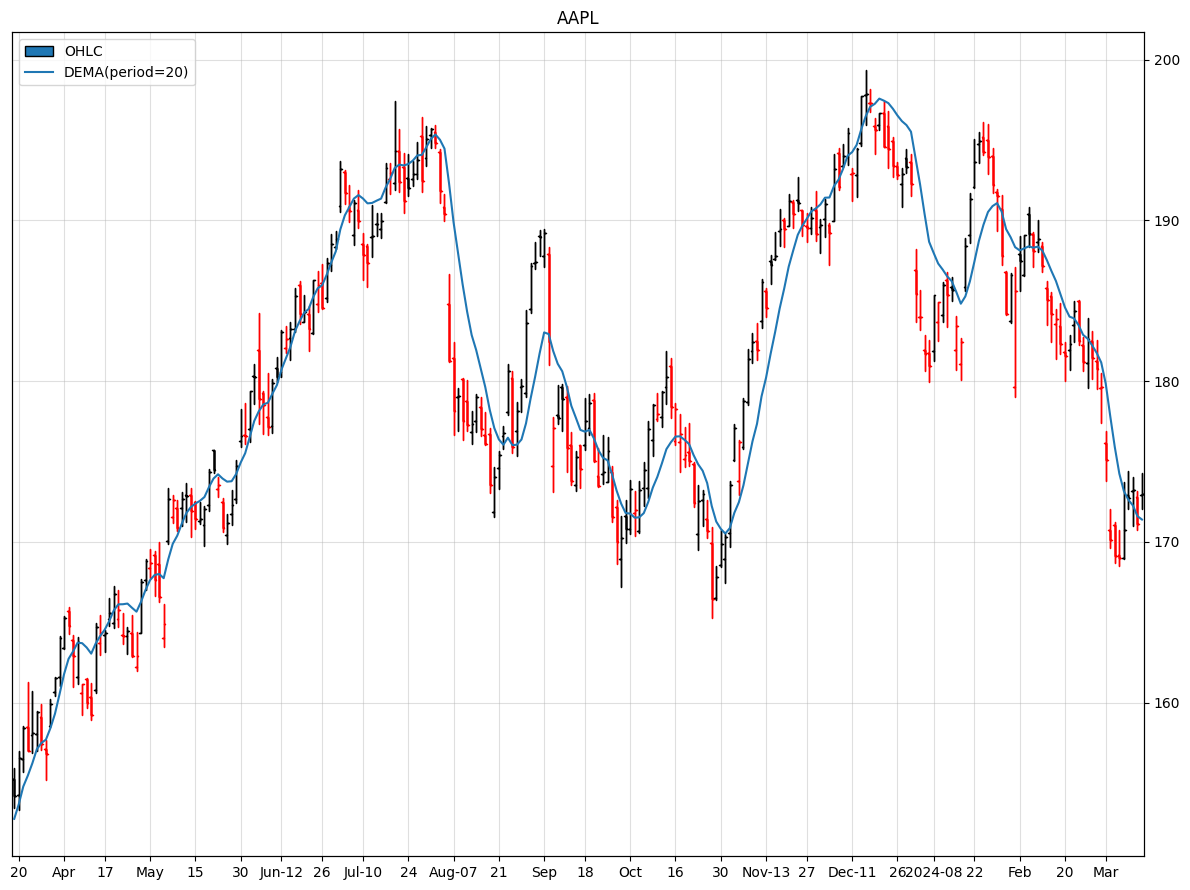

In [18]:
max_bars = 250

indicators = [
    OHLC(),
    DEMA(20),
]

chart = Chart(title=ticker, max_bars=max_bars)
chart.plot(prices, indicators)